In [1]:
from functools import partial
import copy
import numpy as np
import matplotlib.pyplot as plt
import cProfile
from mpl_toolkits import mplot3d
import scipy.spatial

# Local imports
import oggm
from oggm.core.massbalance import LinearMassBalance, ScalarMassBalance
from oggm.core.inversion import find_sia_flux_from_thickness
from oggm import utils, cfg
from oggm.cfg import SEC_IN_DAY
from oggm.cfg import SEC_IN_YEAR
from oggm.core.sia2d import Upstream2D
from oggm.exceptions import InvalidParamsError
cfg.initialize(logging_level='WARNING')

# Tests
from oggm.tests.funcs import (dummy_bumpy_bed, dummy_constant_bed,
                              dummy_constant_bed_cliff,
                              dummy_mixed_bed, dummy_constant_bed_obstacle,
                              dummy_noisy_bed, dummy_parabolic_bed,
                              dummy_trapezoidal_bed, dummy_width_bed,
                              dummy_width_bed_tributary, bu_tidewater_bed,
                              dummy_bed_tributary_tail_to_head)

# after oggm.test
import matplotlib.pyplot as plt

from oggm.core.flowline import (KarthausModel, FluxBasedModel,
                                MassRedistributionCurveModel,
                                MassConservationChecker)
from oggm.tests.ext.sia_fluxlim import MUSCLSuperBeeModel

FluxBasedModel = partial(FluxBasedModel, inplace=True)
KarthausModel = partial(KarthausModel, inplace=True)
MUSCLSuperBeeModel = partial(MUSCLSuperBeeModel, inplace=True)


2022-06-09 18:34:41: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-06-09 18:34:41: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-06-09 18:34:41: oggm.cfg: Multiprocessing: using all available processors (N=16)


In [2]:
# You can try with or without multiprocessing: with two glaciers, OGGM could run on two processors
cfg.PARAMS['use_multiprocessing'] = True
# Store model geometry, this this no longer the default to be True in the development version
cfg.PARAMS['store_model_geometry'] = True

2022-06-09 18:34:42: oggm.cfg: Multiprocessing switched ON after user settings.
2022-06-09 18:34:42: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


In [3]:
# Define folder where to store the results of the computations for all glaciers
cfg.PATHS['working_dir'] = '/Users/amedin/Research/NumericalSumma/Janine/oggm_output/OGGM-GettingStarted'
cfg.PATHS['working_dir']

'/Users/amedin/Research/NumericalSumma/Janine/oggm_output/OGGM-GettingStarted'

In [4]:
cfg.PARAMS

ParamsLoggingDict([('has_internet', True),
                   ('dl_cache_readonly', False),
                   ('use_multiprocessing', True),
                   ('use_mp_spawn', False),
                   ('mp_processes', 16),
                   ('lru_maxsize', 100),
                   ('continue_on_error', False),
                   ('grid_dx_method', 'square'),
                   ('topo_interp', 'cubic'),
                   ('use_intersects', True),
                   ('use_compression', True),
                   ('border', 40),
                   ('mpi_recv_buf_size', 131072),
                   ('use_multiple_flowlines', True),
                   ('filter_min_slope', True),
                   ('auto_skip_task', False),
                   ('correct_for_neg_flux', True),
                   ('filter_for_neg_flux', False),
                   ('run_mb_calibration', False),
                   ('rgi_version', '62'),
                   ('use_rgi_area', True),
                   ('compress_

In [5]:
def test_parabolic_bed(glen_a,yrs,models,flss,mb0):

    lens = []
    surface_h = []
    volume = []
    widths = []

    for model, fls in zip(models, flss):
        mb = mb0
        
        print(model,fls)

        model = model(fls, mb_model=mb, glen_a=glen_a,
                      fixed_dt=10 * SEC_IN_DAY)

        length = yrs * 0.
        vol = yrs * 0.
        for i, y in enumerate(yrs):
            model.run_until(y)
            assert model.yr == y
            length[i] = fls[-1].length_m
            vol[i] = fls[-1].volume_km3
        lens.append(length)
        volume.append(vol)
        widths.append(fls[-1].widths_m.copy())
        surface_h.append(fls[-1].surface_h.copy())
        
    bed_h = fls[-1].bed_h
    return(lens, volume, surface_h, widths, bed_h)

In [6]:
dx = 100 #map resolution (m)
dy = 20 #map resolution (m)
dxdy=dx*dy
dt = 1.0
y0 = 1 #the starting year
t_total = 700
timesteps =int(t_total/dt)
interval = t_total/50. #timesteps that are graphed
yrs = np.arange(y0, t_total, 2)

x_m = 200*100
x_s = 700.0 #for cliff
y_m = 300#0.0
b_0 = 50#0.0 #cliff base height

max_elev = 3000.
min_elev = 1000.
slope_elevation = (max_elev-min_elev)/(x_m)

surface_h = np.linspace(max_elev,min_elev,200) #at every width, need a height
bed_h = surface_h
widths = surface_h * 0. + 3.0

x = np.arange(1,x_m, dx, dtype='int64')

y = np.arange(1, y_m+dy, dy, dtype='int64')
Nx = len(x)
Ny = len(y)
Mny = int(Ny/2)

ELA = 2800. #ELA (m)
mdot_grad = 3. #mbgradient (mm/yr/m, default=3.)
mdot_con = 10. #mb (mm/yr)

mdot_0 = 2.0 #initial accumulation

# coefficients
A = 2.4e-24#1.0e-16 #Glen's flow law parameter A
n = 3.0
g = 9.80665 #gravity m/s^2
rho = 900.0
Gamma = 2.0*A*(rho*g)**n/(n+2) #used to shorten equations later
c_stab = 0.124#0.165

SEC_IN_YEAR = 31536000

min_ice_thick_for_length = 0.0

cfl = 0.124 #forward time stepping stability criteria
max_dt = 967224.0 #max timestep in seconds

B = np.zeros((Nx, Ny)) #Bed topo, 2D array, the topography
init_ice_think = np.zeros((Nx, Ny)) #2d array the initial ice thickness

length = []
volume = []
SurfaceElevation = []
width = []

In [7]:
# define model and beds
models = [KarthausModel, FluxBasedModel,MUSCLSuperBeeModel]
flss = [dummy_constant_bed(), dummy_parabolic_bed(), dummy_parabolic_bed()]
mymodels=["Flux Based ","MUSCL SB "]
mymodels=[s+ " Parabolic Bed" for s in mymodels]
modelnames=["Karthaus Constant Bed"] + mymodels

In [8]:
def test_parabolic_bed(glen_a,yrs,models,flss,mb0):

    lens = []
    surface_h = []
    volume = []
    widths = []

    for model, fls in zip(models, flss):
        mb = mb0
        
        print(model,fls)

        model = model(fls, mb_model=mb, glen_a=glen_a,
                      fixed_dt=10 * SEC_IN_DAY)

        length = yrs * 0.
        vol = yrs * 0.
        for i, y in enumerate(yrs):
            model.run_until(y)
            assert model.yr == y
            length[i] = fls[-1].length_m
            vol[i] = fls[-1].volume_km3
        lens.append(length)
        volume.append(vol)
        widths.append(fls[-1].widths_m.copy())
        surface_h.append(fls[-1].surface_h.copy())
        
    bed_h = fls[-1].bed_h
    return(lens, volume, surface_h, widths, bed_h)

In [9]:
# run models and linear MB and save
#  input is ELA (m, required), gradient (mm/yr/m, default=3.), max mb cap (mm/yr, default=none)
mb = LinearMassBalance(ELA,mdot_grad)
file = 'test_parabolic_bed_linear' #to save
print(mb)
lens1, volume1, surface_h1, widths1, bed_h1 = test_parabolic_bed(2.4e-24,yrs,models,flss,mb)
np.savez(file, lens=lens1,volume=volume1,surface_h=surface_h1,widths=widths1,bed_h=bed_h1)  

<oggm.MassBalanceModel>
  Class: LinearMassBalance
  Attributes:
    - hemisphere: nh
    - rho: 900.0
    - orig_ela_h: 2800.0
    - ela_h: 2800.0
    - grad: 3.0

functools.partial(<class 'oggm.core.flowline.KarthausModel'>, inplace=True) [<oggm.core.flowline.RectangularBedFlowline object at 0x7fd6d08a4700>]
functools.partial(<class 'oggm.core.flowline.FluxBasedModel'>, inplace=True) [<oggm.core.flowline.ParabolicBedFlowline object at 0x7fd6b028aa60>]
functools.partial(<class 'oggm.tests.ext.sia_fluxlim.MUSCLSuperBeeModel'>, inplace=True) [<oggm.core.flowline.ParabolicBedFlowline object at 0x7fd6b028ae20>]


In [10]:
# run models on scalar MB and save
#  input is mb (mm/yr, default =0)
#   if you make this too positive it will grow out of domain boundaries (- or +10. is okay)
mb = ScalarMassBalance(mdot_con)
file = 'test_parabolic_bed_scalar' #to save
print(mb)
lens1, volume1, surface_h1, widths1, bed_h1 = test_parabolic_bed(2.4e-24,yrs,models,flss,mb)
np.savez(file, lens=lens1,volume=volume1,surface_h=surface_h1,widths=widths1,bed_h=bed_h1)  

<oggm.MassBalanceModel>
  Class: ScalarMassBalance
  Attributes:
    - hemisphere: nh
    - rho: 900.0

functools.partial(<class 'oggm.core.flowline.KarthausModel'>, inplace=True) [<oggm.core.flowline.RectangularBedFlowline object at 0x7fd6d08a4700>]
functools.partial(<class 'oggm.core.flowline.FluxBasedModel'>, inplace=True) [<oggm.core.flowline.ParabolicBedFlowline object at 0x7fd6b028aa60>]
functools.partial(<class 'oggm.tests.ext.sia_fluxlim.MUSCLSuperBeeModel'>, inplace=True) [<oggm.core.flowline.ParabolicBedFlowline object at 0x7fd6b028ae20>]


In [11]:
# numberical Methods
use_E = 0 #Euler
use_TVD = 1 #TVD runge Kutta Method
use_nTVD = 0 #Non TVD Runge Kutta Method

#needs to be added
use_minmod = 0 #minmod function
use_superbee = 1 #superbee function

#shallow ice solving method
use_MUSCL = 0
use_M2 = 0
use_M3 = 0
use_upstream = 1

use_cliff = 0

#Pick Bed Shape
use_rectangle = 1
use_trapazoid = 0
use_parabolic = 0

#Pick Mass Balance equation
use_steadyState = 0
use_Scalar = 1
use_linear = 0

#Plots
#Time Evolution length
plt_TEL = 1
#Time Evolution Volume
plt_TEV = 1
#Surface elevation
plt_SE = 1
#Surface Width
plt_SW = 1




In [12]:
#for use_trapazoid
gam = 2
if gam == 2:
    theta = 45

In [13]:
if use_cliff == 1:
    for yd in range(Ny):
        for xd in range(Nx):
            if x[xd] < x_s:
                B[xd][yd] = b_0
            
if use_rectangle == 1:
    for yd in range(Ny):
        for xd in range(Nx):
            x0 = np.linspace(3000.,1000.,200)
            if y[yd]< dy:
                B[xd][yd] = 2000
            if y[yd]> y_m:
                B[xd][yd] = 2000
            B[xd][yd] = B[xd][yd]+x0[xd]
    Mny = int(Ny/2)
            
if use_trapazoid == 1:
    w0 = y_m-2*b_0
    for yd in range(Ny):
        for xd in range(Nx):
            if y[yd] <= (y_m-w0)/gam:
                base = (y_m-w0)/gam-y[yd]
                B[xd][yd] = base*np.tan(theta) #-(slope_elevation)*x[xd]+max_elev
            if y[yd] >= (y_m-w0)/gam+w0:
                base = y[yd]-(y_m-w0)/gam-w0
                B[xd][yd] = base*np.tan(theta) #-(slope_elevation)*x[xd]+max_elev
            B[xd][yd] = B[xd][yd]-(slope_elevation)*x[xd]+max_elev
    Mny = int(Ny/2)
    
if use_parabolic == 1:
    Ps=0.003
    for yd in range(Ny):
        think = []
        for xd in range(Nx):
            #B[xd][yd] = Ps*(y[yd]-y_m/2)**2
            #B[xd][yd] = B[xd][yd]-(slope_elevation)*x[xd]+max_elev
            x0 = np.linspace(3000.,1000.,200)
            B[xd][yd]=Ps*(yd-Ny/2)**2+x0[xd]


    Mny = np.argmin(B[0][:])           
Bx,By= np.meshgrid(x,y, indexing = 'ij') #2D array of bed size/shape
#ax = plt.axes(projection='3d')
#ax.plot_surface(Bx, By, B, linewidths=1.0)

#print(B)

In [14]:
# standard minmod functioin
def minmod(a,b):
    sign = (np.sign(a)+np.sign(b))
    minmod = sign/2*(np.minimum(np.abs(a), np.abs(b)))
    return minmod

def superbee(r):
    #r = (H-Hm)/(Hp-H) #gives divide by 0 errors, makes sense when the height of the glacier is 0
    superbee =np.maximum(0,np.minimum(2.*r,1), np.minimum(r,2.)) 
    return superbee

# flux
def flux(sjpl, sjml, sjplp, sjmlp, sjlp, sjl):
    flux = (((((sjpl-sjml)+sjplp-sjmlp)**2.) / (4*dy)**2.)+(sjlp-sjl)**2./dx**2 )**((n-1.)/2.)
    return flux

# Shallow Ice approximation
def L(Dup, Sup, S, Ddn, Sdn, d):
    L=((Dup * (Sup - S))/d - (Ddn * (S - Sdn))/d)/d #equation 36 Jarosh 2013
    return L


# index
def H_index(h1, h2):
    H_index = 0.5*(h1+h2)
    return H_index

# H up index
def H_plus(H, Hp, H2p):
    if use_minmod == 1:
        H_plus = Hp - 0.5*minmod((Hp-H),(H2p-Hp))*(H2p-Hp)
    if use_superbee == 1:
        H_plus = Hp - 0.5*superbee(Hp ,H, H2p)*(H2p-Hp)
    return H_plus

# H down index
def H_min(H, Hm, Hp):
    if use_minmod == 1:
        H_min = H + 0.5*minmod((H-Hm),(Hp-H))*(Hp-H)
    if use_superbee == 1:
        H_min = H + 0.5*superbee(H,Hm,Hp)*(Hp-H)
        #if Hp - H ==0:
        #    H_min = H
        #else:
        #    H_min = H + 0.5*superbee(H,Hm,Hp)*(Hp-H)
    return H_min  
    
# Methods    
# Euler
def E(u, Lu, deltat):
    E = u-deltat*Lu
    return E

# TVD second order Runge-Kutta method
def TVDu1(u, Lu, deltat):
    TVDu1 = u+deltat*Lu
    return TVDu1

def TVD(u, Lu, L1, deltat):
    TVD = u+(0.5)*deltat*Lu+1/2*deltat*L1
    return TVD

# non TVD Runge-Kutta method method
def nTVDu1(u, Lu, deltat):
    nTVDu1 = u-20*deltat*Lu
    return nTVDu1

def nTVD(u, Lu, L1, deltat):
    nTVD = u+(41.0/40.0)*deltat*Lu-1.0/40.0*deltat*L1
    return nTVD

def accumulationss(x,mdot_0,n,x_m): 
    mdot = ((n*mdot_0)/(x_m**(2.*n-1.)))*x**(n-1.)*(abs(x_m-x)**(n-1.))*(x_m-2.*x) # Eq. 54 Jarosch 2013 
    mdot[x>x_m] = 0.
    return mdot

def accumulationl(heights):
    mdot = (heights-ELA)*mdot_grad
    return mdot

def trapezoidal_area(xyz):
    """Calculate volume under a surface defined by irregularly spaced points
    using delaunay triangulation. "x,y,z" is a <numpoints x 3> shaped ndarray."""
    d = scipy.spatial.Delaunay(xyz[:,:2])
    tri = xyz[d.vertices]

    a = tri[:,0,:2] - tri[:,1,:2]
    b = tri[:,0,:2] - tri[:,2,:2]
    vol = np.cross(a, b) @ tri[:,:,2]
    return vol.sum() / 6.0
def widths(H):
    #compute the widths out of H and the bed shape
    if use_rectangle ==1:
        width = y_m
    if use_parabolic == 1:
        width = np.sqrt(4*H/Ps)
    if use_trapazoid == 1:
        width = 3
    return width
def volume_km3(H):
    volume_m3 = np.sum(H*dxdy)
    return volume_km3*1e-9
    

In [15]:
# accumulation
m_dot = np.zeros((Nx,Ny))
if use_steadyState==1:
    mdot = accumulationss(x, mdot_0, n, x_m)
    for xd in range(Nx):
        for yd in range(Ny):
            m_dot[xd][yd] = mdot[xd]  
    
if use_linear==1:
    for xd in range(Nx):
        for yd in range(Ny):
            mdot = accumulationl(B[xd][yd])
            m_dot[xd][yd] = mdot
            
if use_Scalar==1:
    for xd in range(Nx):
        for yd in range(Ny):
            m_dot[xd][yd] = mdot_con/SEC_IN_YEAR/rho

In [16]:
# finite difference index y direction
k = np.arange(0, Nx)
kp = np.hstack([np.arange(1,Nx),Nx-1])
kpp = np.hstack([np.arange(2, Nx), Nx-1, Nx-1])
km = np.hstack([0, np.arange(0, Nx-1)])
kmm = np.hstack([0, 0, np.arange(0, Nx-2)])

# finite difference index x direction
l = np.arange(0, Ny)
lp = np.hstack([np.arange(1,Ny),Ny-1])
lpp = np.hstack([np.arange(2, Ny), Ny-1, Ny-1])
lm = np.hstack([0, np.arange(0, Ny-1)])
lmm = np.hstack([0, 0, np.arange(0, Ny-2)])

In [17]:
#M2 method
def M2():
    S=B#np.zeros(Nx)
    for i in range(0, timesteps-1):
        stab_t = 0.
        while stab_t<dt:
            H = S-B
            
            # calculate the l index
            H_up = H_index(H[jp],H[j])
            H_down = H_index( H[j],H[jm] )
        
            # calculate f (flux)
            f_plus = flux(S[jp],S[j])
            f_min = flux(S[j],S[jm])
            
            # Calculate Diffusivity
            D_up = Gamma * H_up**(n+2) * f_plus
            D_dn = Gamma * H_down**(n+2) * f_min 

            # calculate deltat and stab_t
            dt_stab = c_stab * dx**2. / max(np.max(np.abs(D_up)),np.max(np.abs(D_dn)))
            deltat = min(dt_stab,dt-stab_t)
            stab_t = stab_t + deltat
        

            # the time step
            div_q = L(D_up,S[jp], S[j], D_dn, S[jm]) #equation 36 Jarosh 2013
            S = S[j] + (m_dot+div_q)*deltat #equation 35 Jarosh 2013
            S = np.maximum(S,B)
             
        if np.mod(i,interval)==0.0:
            #print('timestep: ', i)
            plt.plot(x/1000,S, '-r')

In [18]:
#upstream method
def upstream():
    #Initial conditions
    S = B
    for i in range(0, timesteps+1):
        stab_t = 0.
        while stab_t<dt:
            H = S-B #H = ice thinkness, S = Surface height, B = bed topography  
            
            #optimize
            Sklp = S[k][:,lp]
            Sklm = S[k][:,lm]
            Skplp = S[kp][:,lp]
            Skplm = S[kp][:,lm]
            Skpl = S[kp][:,l]
            Skl = S[k][:,l]
            Skmlp = S[km][:,lp]
            Skmlm = S[km][:,lm]
            Skml = S[km][:,l]
            
            #calculate l indecies
            Hl = H[k][:,l]
            Hlp = H[k][:,lp]
            Hlm = H[k][:,lm]
            
            H_l_up = H_index( Hlp , Hl )
            H_l_down = H_index( Hl , Hlm )
            
            # l upstream    
            H_l_upstream_up = np.zeros((Nx,Ny))
            H_l_upstream_up[S[k][:,lp]>S[k][:,l]] = Hlp[S[k][:,lp]>S[k][:,l]]
            H_l_upstream_up[S[k][:,l]>= S[k][:,lp]] = Hl[S[k][:,l]>= S[k][:,lp]]
                    
            H_l_upstream_down = np.zeros((Nx,Ny))
            H_l_upstream_down[S[k][:,l] > S[k][:,lm]] = Hl[S[k][:,l] > S[k][:,lm]]
            H_l_upstream_down[S[k][:,lm]>=S[k][:,l]] = Hlm[S[k][:,lm]>=S[k][:,l]]          
            
            #calculate l flux
            f_l_plus = flux(Skpl, Skml, Skplp, Skmlp, Sklp, Skl)
            f_l_min = flux(Skpl, Skml, Skplm, Skmlm, Skl, Sklm)
            
            # calculate l Diffusivity
            D_l_up = Gamma * H_l_up**(n+1) * H_l_upstream_up * f_l_plus
            D_l_dn = Gamma * H_l_down**(n+1) * H_l_upstream_down * f_l_min
        
            #calculate j indecies 
            Hk = H[k][:,l]
            Hkp = H[kp][:,l]
            Hkm = H[km][:,l]
            
            H_k_up = H_index( Hkp , Hk )
            H_k_down = H_index( Hk , Hkm )
            
            # j upstream    
            H_k_upstream_up = np.zeros((Nx,Ny))
            H_k_upstream_up[Skpl>Skl] = Hkp[Skpl>Skl]
            H_k_upstream_up[Skl>= Skpl] = Hk[Skl>= Skpl]
                    
            H_k_upstream_down = np.zeros((Nx,Ny))
            H_k_upstream_down[Skl > Skml] = Hk[Skl > Skml]
            H_k_upstream_down[Skml>=Skl] = Hkm[Skml>=Skl]
            
            #calculate j flux
            f_k_plus = flux(Sklp, Sklm, Skplp, Skplm, Skpl, Skl)
            f_k_min = flux(Sklp, Sklm, Skmlp, Skmlm, Skl, Skml)
                
            # calculate j Diffusivity
            D_k_up = Gamma * H_k_up**(n+1) * H_k_upstream_up * f_k_plus
            D_k_dn = Gamma * H_k_down**(n+1) * H_k_upstream_down * f_k_min
        
            # calculate delta t and stab_t
            dt_stab = c_stab * min(dx**2., dy**2.) / max(np.max(np.abs(D_k_up)), np.max(np.abs(D_k_dn)), np.max(np.abs(D_l_dn)), np.max(np.abs(D_l_dn)))
            deltat = min(dt_stab,dt-stab_t)
            
            if deltat > max_dt:
                deltat = max_dt
            
            stab_t = stab_t + deltat
    
            # the timestep
            div_k = L(D_k_up ,Skpl ,Skl, D_k_dn, Skml, dx) #equation 36 Jarosh 2013
            div_l = L(D_l_up ,Sklp ,Skl, D_l_dn, Sklm, dy) #equation 36 Jarosh 2013
            div_q = div_k+div_l
            
            S= Skl + (m_dot+div_q)*deltat #equation 35 Jarosh 2013
            
            S = np.maximum(S,B)
            H = S-B
            #print(S)
        
        if np.mod(i,interval)==0.0:
            print('year: ', i)
            plt.plot(y,S[1][:], '-g') 
        
        if i == timesteps:
            for j in range(Nx):
                SurfaceElevation.append(S[j][Mny])
                #wid = np.where(H[k,:]!=0)
                #if np.size(wid) == 0:
                #    width.append(0)
                #else:
                #    width.append(y[wid[0][-1]]-y[wid[0][0]])
                #print(H[k,Mny])
                width.append(widths(H[k,Mny]))
            
        Dif = np.nonzero(S[:,Mny]-B[:,Mny])

        vol = np.sum(H*dxdy)#*1e-9
        #print(vol)
        #print(B[:,Mny])
        
        length.append(x[Dif[0][-1]])
        volume.append(vol)

In [19]:
#MUSCL Scheme 
def MUSCL():
    S=B #Initial conditions
    for i in range(0, timesteps+1):
        stab_t = 0
        while stab_t<dt:
            H = S-B
            #print("t = ", i)
            #print(H)
                
            # at the j+1/2 index
            r_j_min_up = (H[j][:,l]-H[jm][:,l])/(H[jp][:,l]-H[j][:,l])
            H_j_min_up = H[j][:,l] + 0.5 * superbee(r_j_min_up)*(H[jp][:,l] - H[j][:,l])
            
            r_j_plus_up = (H[jp][:,l]-H[j][:,l])/(H[jpp][:,l]-H[jp][:,l])
            H_j_plus_up = H[jp][:,l] - 0.5 * superbee(r_j_plus_up)*(H[jpp][:,l] - H[jp][:,l])
            
                
            # at the j-1/2 index
            r_j_min_down = (H[jm][:,l]-H[jmm][:,l])/(H[j][:,l]-H[jm][:,l])
            H_j_min_down = H[jm][:,l] + 0.5 * superbee(r_j_min_down)*(H[j][:,l] - H[jm][:,l])
            
            r_j_plus_down = (H[j][:,l]-H[jm][:,l])/(H[jp][:,l]-H[j][:,l])
            H_j_plus_down = H[j][:,l] - 0.5 * superbee(r_j_plus_down)*(H[jp][:,l] - H[j][:,l])
            
            # at the l+1/2 index
            r_l_min_up = (H[j][:,l]-H[j][:,lm])/(H[j][:,lp]-H[j][:,l])
            H_l_min_up = H[j][:,l] + 0.5 * superbee(r_l_min_up)*(H[j][:,lp] - H[j][:,l])
            
            r_l_plus_up = (H[j][:,lp]-H[j][:,l])/(H[j][:,lpp]-H[j][:,lp])
            H_l_plus_up = H[j][:,lp] - 0.5 * superbee(r_l_plus_up)*(H[j][:,lpp] - H[j][:,lp])
            
                
            # at the l-1/2 index
            r_l_min_down = (H[j][:,lm]-H[j][:,lmm])/(H[j][:,l]-H[j][:,lm])
            H_l_min_down = H[j][:,lm] + 0.5 * superbee(r_l_min_down)*(H[j][:,l] - H[j][:,lm])
            
            r_l_plus_down = (H[j][:,l]-H[j][:,lm])/(H[j][:,lp]-H[j][:,l])
            H_l_plus_down = H[j][:,l] - 0.5 * superbee(r_l_plus_down)*(H[j][:,lp] - H[j][:,l])
            
           
            
            Sjlp = S[j][:,lp]
            Sjlm = S[j][:,lm]
            Sjplp = S[jp][:,lp]
            Sjplm = S[jp][:,lm]
            Sjpl = S[jp][:,l]
            Sjl = S[j][:,l]
            Sjmlp = S[jm][:,lp]
            Sjmlm = S[jm][:,lm]
            Sjml = S[jm][:,l]
                
            f_j_plus = flux(Sjlp, Sjlm, Sjplp, Sjplm, Sjpl, Sjl)
            #print('f_j_plus = ', f_j_plus)
            f_j_min = flux(Sjlp, Sjlm, Sjmlp, Sjmlm, Sjl, Sjml)
            #print('f_j_min = ', f_j_min)
            
            #calculate l flux
            f_l_plus = flux(Sjpl, Sjml, Sjplp, Sjmlp, Sjlp, Sjl)
            #print('f_l_plus = ', f_l_plus)
            f_l_min = flux(Sjpl, Sjml, Sjplm, Sjmlm, Sjl, Sjlm)
            #print('f_l_min = ', f_l_min)
                
            # calculate j Diffusivity
            D_j_up_m = Gamma * H_j_min_up**(n+2.) * f_j_plus #Equation 30 Jarosch 2013
            D_j_up_p = Gamma * H_j_plus_up**(n+2.) * f_j_plus #Equation 30 Jarosch 2013
            D_j_up_min = np.minimum(D_j_up_m, D_j_up_p) #equation 31 Jarosch 2013
            D_j_up_max = np.maximum(D_j_up_m, D_j_up_p) #equation 32 Jarosch 2013
                
            D_j_dn_m = Gamma * H_j_min_down**(n+2) * f_j_min #Equation 30 Jarosch 2013
            D_j_dn_p = Gamma * H_j_plus_down**(n+2) * f_j_min #Equation 30 Jarosh 2013
            D_j_dn_min = np.minimum(D_j_dn_m, D_j_dn_p) #equation 31 Jarosch 2013
            D_j_dn_max = np.maximum(D_j_dn_m, D_j_dn_p) #equatioon 32 Jarosch 2013
                
            #equation 33 jarosh 2013
            D_j_up = np.zeros((Nx, Ny))
            
            D_j_up[np.logical_and(Sjpl<=Sjl,H_j_min_up<=H_j_plus_up)] = D_j_up_min[np.logical_and(Sjpl<=Sjl,H_j_min_up<=H_j_plus_up)]
            D_j_up[np.logical_and(Sjpl<=Sjl,H_j_min_up>H_j_plus_up)] = D_j_up_max[np.logical_and(Sjpl<=Sjl,H_j_min_up>H_j_plus_up)]
            D_j_up[np.logical_and(Sjpl>Sjl,H_j_min_up<=H_j_plus_up)] = D_j_up_max[np.logical_and(Sjpl>Sjl,H_j_min_up<=H_j_plus_up)]
            D_j_up[np.logical_and(Sjpl>Sjl,H_j_min_up>H_j_plus_up)] = D_j_up_min[np.logical_and(Sjpl>Sjl,H_j_min_up>H_j_plus_up)]
        
            D_j_dn = np.zeros((Nx,Ny))
            
            D_j_dn[np.logical_and(Sjl<=Sjml,H_j_min_down<=H_j_plus_down)] = D_j_dn_min[np.logical_and(Sjl<=Sjml,H_j_min_down<=H_j_plus_down)]
            D_j_dn[np.logical_and(Sjl<=Sjml,H_j_min_down>H_j_plus_down)] = D_j_dn_max[np.logical_and(Sjl<=Sjml,H_j_min_down>H_j_plus_down)]
            D_j_dn[np.logical_and(Sjl>Sjml,H_j_min_down<=H_j_plus_down)] = D_j_dn_max[np.logical_and(Sjl>Sjml,H_j_min_down<=H_j_plus_down)]
            D_j_dn[np.logical_and(Sjl>Sjml,H_j_min_down>H_j_plus_down)] = D_j_dn_min[np.logical_and(Sjl>Sjml,H_j_min_down>H_j_plus_down)]
            
            # calculate l Diffusivity
            D_l_up_m = Gamma * H_l_min_up**(n+2.) * f_l_plus #Equation 30 Jarosch 2013
            D_l_up_p = Gamma * H_l_plus_up**(n+2.) * f_l_plus #Equation 30 Jarosch 2013
            D_l_up_min = np.minimum(D_l_up_m, D_l_up_p) #equation 31 Jarosch 2013
            D_l_up_max = np.maximum(D_l_up_m, D_l_up_p) #equation 32 Jarosch 2013
                
            D_l_dn_m = Gamma * H_l_min_down**(n+2) * f_l_min #Equation 30 Jarosch 2013
            D_l_dn_p = Gamma * H_l_plus_down**(n+2) * f_l_min #Equation 30 Jarosh 2013
            D_l_dn_min = np.minimum(D_l_dn_m, D_l_dn_p) #equation 31 Jarosch 2013
            D_l_dn_max = np.maximum(D_l_dn_m, D_l_dn_p) #equatioon 32 Jarosch 2013
                
            #equation 33 jarosh 2013
            D_l_up = np.zeros((Nx, Ny))
            
            D_l_up[np.logical_and(Sjlp<=Sjl,H_l_min_up<=H_l_plus_up)] = D_l_up_min[np.logical_and(Sjlp<=Sjl,H_l_min_up<=H_l_plus_up)]
            D_l_up[np.logical_and(Sjlp<=Sjl,H_l_min_up>H_l_plus_up)] = D_l_up_max[np.logical_and(Sjlp<=Sjl,H_l_min_up>H_l_plus_up)]
            D_l_up[np.logical_and(Sjlp>Sjl,H_l_min_up<=H_l_plus_up)] = D_l_up_max[np.logical_and(Sjlp>Sjl,H_l_min_up<=H_l_plus_up)]
            D_l_up[np.logical_and(Sjlp>Sjl,H_l_min_up>H_l_plus_up)] = D_l_up_min[np.logical_and(Sjlp>Sjl,H_l_min_up>H_l_plus_up)]
        
            D_l_dn = np.zeros((Nx,Ny))
            
            D_l_dn[np.logical_and(Sjl<=Sjlm,H_l_min_down<=H_l_plus_down)] = D_l_dn_min[np.logical_and(Sjl<=Sjlm,H_l_min_down<=H_l_plus_down)]
            D_l_dn[np.logical_and(Sjl<=Sjlm,H_l_min_down>H_l_plus_down)] = D_l_dn_max[np.logical_and(Sjl<=Sjlm,H_l_min_down>H_l_plus_down)]
            D_l_dn[np.logical_and(Sjl>Sjlm,H_l_min_down<=H_l_plus_down)] = D_l_dn_max[np.logical_and(Sjl>Sjlm,H_l_min_down<=H_l_plus_down)]
            D_l_dn[np.logical_and(Sjl>Sjlm,H_l_min_down>H_l_plus_down)] = D_l_dn_min[np.logical_and(Sjl>Sjlm,H_l_min_down>H_l_plus_down)]
                
            # calculate delta t and stab_t
            dt_stab = c_stab * dx**2. / max(np.max(abs(D_j_up)),np.max(abs(D_j_dn)), np.max(abs(D_l_up)),np.max(abs(D_l_dn)))
            deltat = min(dt_stab,dt-stab_t)
            stab_t = stab_t + deltat
            
            
            # the time step
            div_j = L(D_j_up,Sjpl, Sjl, D_j_dn, Sjml, dx) #equation 36 Jarosh 2013
            div_l = L(D_l_up,Sjlp, Sjl, D_l_dn, Sjlm, dy) #equation 36 Jarosh 2013
            div_q = div_j+div_l
            S = Sjl + (m_dot+div_q)*deltat #equation 35 Jarosh 2013
            S = np.maximum(S,B)
            #print('S = ')
            #print(S[:,0])
  
        if np.mod(i,interval)==0.0:
            plt.plot(x/1000,S, '-b')

/var/folders/r_/xbzx7gps4nl_p1t__pq8v0jx1bngzm/T/ipykernel_10305/3157077824.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  dt_stab = c_stab * min(dx**2., dy**2.) / max(np.max(np.abs(D_k_up)), np.max(np.abs(D_k_dn)), np.max(np.abs(D_l_dn)), np.max(np.abs(D_l_dn)))


year:  0
year:  14
year:  28
year:  42
year:  56
year:  70
year:  84
year:  98
year:  112
year:  126
year:  140
year:  154
year:  168
year:  182
year:  196
year:  210
year:  224
year:  238
year:  252
year:  266
year:  280
year:  294
year:  308
year:  322
year:  336
year:  350
year:  364
year:  378
year:  392
year:  406
year:  420
year:  434
year:  448
year:  462
year:  476
year:  490
year:  504
year:  518
year:  532
year:  546
year:  560
year:  574
year:  588
year:  602
year:  616
year:  630
year:  644
year:  658
year:  672
year:  686
year:  700


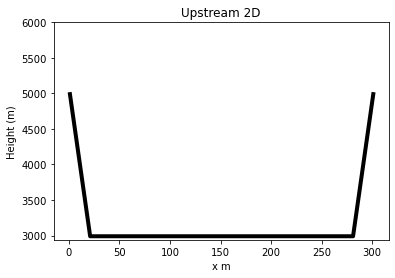

In [20]:
# Run
if use_M2 == 1:
    M2()
    #p1, = plt.plot(0,0, '-r')
    #cProfile.run("M2()")
if use_M3 == 1:
    M3()
    #p2, = plt.plot(0,0, '-m')
    #cProfile.run("M2()")
if use_upstream == 1:
    upstream()
    p3, = plt.plot(0,0, '-g')
    #cProfile.run("upstream()")
if use_MUSCL == 1:
    MUSCL()
    #p4, = plt.plot(0,0, '-b')
    #cProfile.run("MUSCL()")
p5, = plt.plot(y,B[1,:], '-k', linewidth = 4)
plt.xlabel('x m')
plt.ylabel('Height (m)')
plt.ylim(np.min(B[1,:])-50, 6000)
plt.title("Upstream 2D")
plt.savefig('Glacier Model test')

NameError: name 'volumeups' is not defined

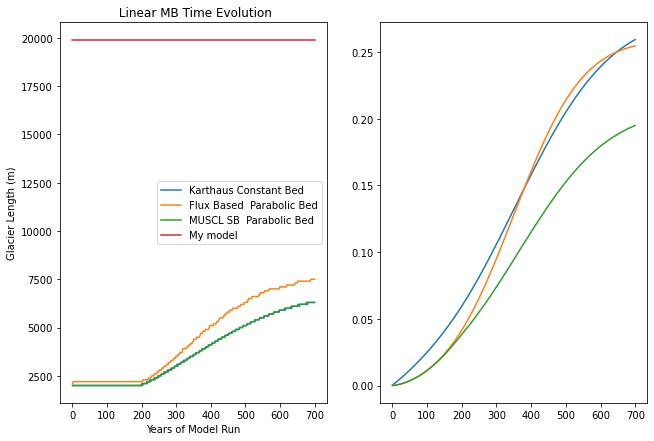

In [21]:
#load and plot models

for j in 1,2:

    if j==1:
        npzfile=np.load("test_parabolic_bed_linear.npz")
        mbname = " Linear MB"
    if j==2:
        npzfile=np.load("test_parabolic_bed_scalar.npz")
        mbname = " Scalar MB"
        
    lens, volume, surface_h, widths, bed_h = npzfile['lens'],npzfile['volume'],npzfile['surface_h'],npzfile['widths'],npzfile['bed_h']
    fig = plt.figure(figsize=(22,7))
    
    ax1 = fig.add_subplot(1,4,1)
    for i, array in enumerate(lens):
        ax1.plot(yrs, array, label = modelnames[i])
    ax1.plot(range(0, timesteps+1),length, label = 'My model')
    ax1.set_xlabel('Years of Model Run')
    ax1.set_ylabel('Glacier Length (m)')
    ax1.legend()
    ax1.set_title(mbname + " Time Evolution")

    ax2 = fig.add_subplot(1,4,2)
    for i, array in enumerate(volume):
        ax2.plot(yrs, array, label = modelnames[i])
    ax2.plot(range(0, timesteps+1), volumeups, label = 'My model')
    ax2.set_xlabel('Years of Model Run')
    ax2.set_ylabel('Glacier Volume (km3)')
    ax2.legend()
    ax2.set_title(mbname + " Time Evolution")

    ax3 = fig.add_subplot(1,4,3)
    for i, array in enumerate(surface_h):
        ax3.plot(dist,array, label = modelnames[i])
    ax3.plot(x, SurfaceElevation, label = 'My model')
    ax3.plot(dist,bed_h, 'k',label = "Bed Elevation")
    ax3.set_xlabel('Distance from Glacier Head (m)')
    ax3.set_ylabel('Elevation (m)')
    ax3.legend()
    ax3.set_title(mbname + " Surface "+str(yrs[-1])+" Years")

    ax4 = fig.add_subplot(1,4,4)
    for i, array in enumerate(widths):
        ax4.plot(dist,array, label = modelnames[i])
    ax4.plot(x,width, label = 'My model')
    ax4.set_xlabel('Distance from Glacier Head (m)')
    ax4.set_ylabel('Width (m)')
    ax4.legend()
    ax4.set_title(mbname + " Surface "+str(yrs[-1])+" Years")

In [ ]:
#plots
#print(length)
print('volume = ', volume)
if plt_TEL == 1:
    plt.plot(range(0, timesteps+1),length)
    plt.xlabel('Years Model ran')
    plt.ylabel('Glacier Length')
    plt.show()
if plt_TEV ==1:
    plt.plot(range(0, timesteps+1), volume)
    plt.xlabel('Years Model ran')
    plt.ylabel('Glacier Volume (km3)')
    plt.show()
if plt_SE ==1:
    plt.plot(x, SurfaceElevation)
    plt.plot(x,B[:,Mny], '-k', linewidth = 4)
    plt.xlabel('Distance from Glacier head')
    plt.ylabel('Glacier Surface Elevation')
    plt.show()
if plt_SW == 1:
    plt.plot(x,width)
    plt.xlabel('Distance from Glacier head')
    plt.ylabel('Glacier Surface Width')
    plt.show()

# 